<a href="https://colab.research.google.com/github/zolfaShefreie/spark_dataframes/blob/main/spark_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

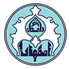







به نام خداوند بخشنده و مهربان 

# **درس: تحلیل سیسیتم داده‌های حجیم**
---

## استاد: دکتر محمدعلی نعمت‌بخش
دستیاران: فاطمه ابراهیمی، امیر سرتیپی، پریسا لطیفی





# Load spark platform on google colab.

In [1]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet 
!apt install openjdk-8-jdk-headless &> /dev/null

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 57.2 MB/s 


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Start to get data

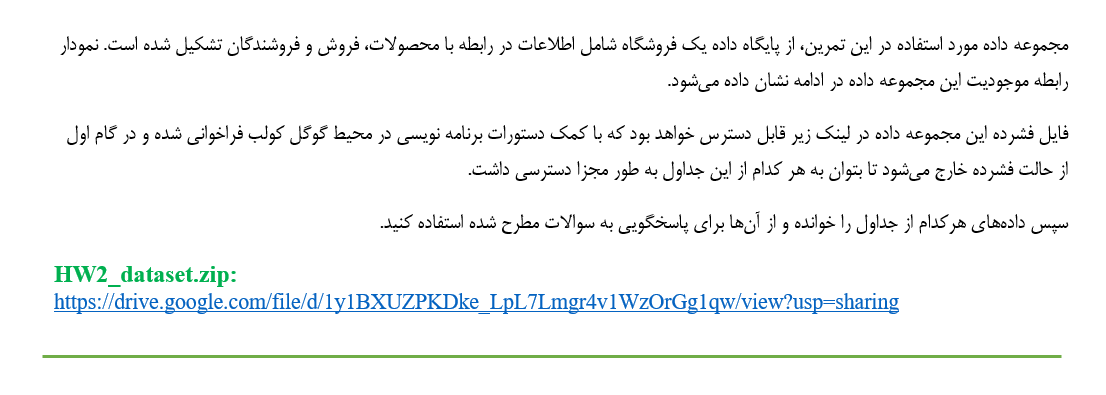
---

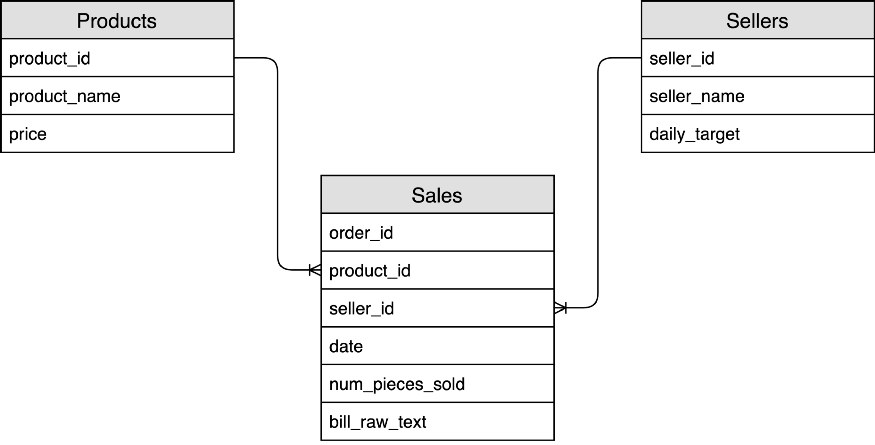


---



DataSet Address on google drive:
 https://drive.google.com/file/d/1y1BXUZPKDke_LpL7Lmgr4v1WzOrGg1qw/view?usp=sharing

In [ ]:
#reading dataset from my googledrive
# !pip install gdown
# !pip install --upgrade --no-cache-dir gdown
# !gdown --id 1y1BXUZPKDke_LpL7Lmgr4v1WzOrGg1qw
# !unzip "./HW2_dataset.zip" -d "./"

adding the dataset to my dirve and mounting here

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = './drive/MyDrive/big_data/HW2_dataset.zip'

In [5]:
import zipfile
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("./")

##import pyspark and set session

In [6]:
import pyspark
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession.builder.appName('df_train').getOrCreate()

##parquet files to spark dataframes

In [8]:
products_df = spark.read.load('./products_parquet', inferSchema=True)
sales_df = spark.read.load('./sales_parquet', inferSchema=True)
sellers_df = spark.read.load('./sellers_parquet', inferSchema=True)

In [9]:
print(products_df.printSchema())
print(sales_df.printSchema())
print(sellers_df.printSchema())

root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- price: string (nullable = true)

None
root
 |-- order_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- num_pieces_sold: string (nullable = true)
 |-- bill_raw_text: string (nullable = true)

None
root
 |-- seller_id: string (nullable = true)
 |-- seller_name: string (nullable = true)
 |-- daily_target: string (nullable = true)

None


In [10]:
from pyspark.sql.functions import col
sales_df = sales_df.withColumn("num_pieces_sold",col("num_pieces_sold").cast("integer")).\
                    withColumn("order_id",col("order_id").cast("integer"))
products_df = products_df.withColumn("price",col("price").cast("integer"))
sellers_df = sellers_df.withColumn("daily_target",col("daily_target").cast("integer"))
products_df.printSchema(), sales_df.printSchema(), sellers_df.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- price: integer (nullable = true)

root
 |-- order_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- num_pieces_sold: integer (nullable = true)
 |-- bill_raw_text: string (nullable = true)

root
 |-- seller_id: string (nullable = true)
 |-- seller_name: string (nullable = true)
 |-- daily_target: integer (nullable = true)



(None, None, None)

# Question_1

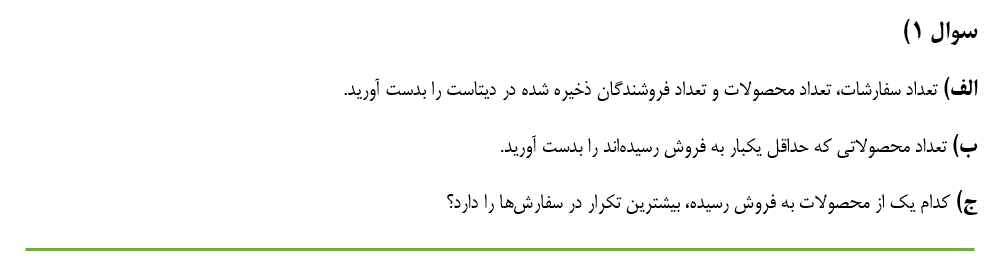

In [11]:
print(f"Products: {products_df.count()}")
print(f"Sales: {sales_df.count()}")
print(f"Sellers: {sellers_df.count()}")

Products: 75000000
Sales: 20000040
Sellers: 10


In [12]:
sales_df.select("product_id").distinct().count()

993429

In [13]:
from pyspark.sql.functions import desc
top_products = sales_df.groupBy("product_id").count().sort(desc("count")).limit(5)
top_products.join(products_df, ['product_id']).show()

+----------+--------+----------------+-----+
|product_id|   count|    product_name|price|
+----------+--------+----------------+-----+
|         0|19000000|       product_0|   22|
|   2316238|       3| product_2316238|   19|
|  36269838|       3|product_36269838|   87|
|  28592106|       3|product_28592106|   76|
|  31136332|       3|product_31136332|  149|
+----------+--------+----------------+-----+



# Question_2

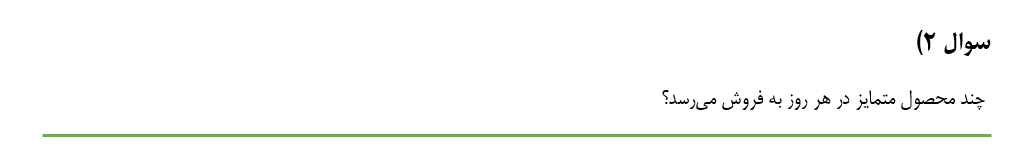

In [14]:
sales_df.dropDuplicates(['product_id', 'date']).groupBy('date').count().show()

+----------+------+
|      date| count|
+----------+------+
|2020-07-03|100017|
|2020-07-07| 99756|
|2020-07-01|100337|
|2020-07-08| 99662|
|2020-07-04| 99791|
|2020-07-10| 98973|
|2020-07-09|100501|
|2020-07-06|100765|
|2020-07-02| 99807|
|2020-07-05| 99796|
+----------+------+



# Question_3

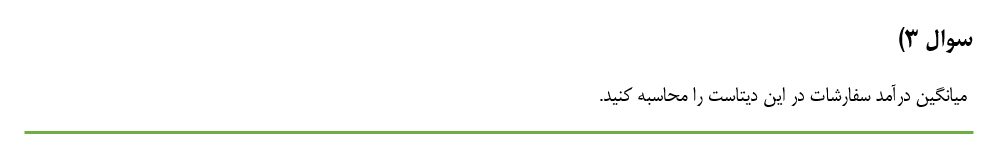

In [15]:
sales_df.join(products_df, sales_df.product_id==products_df.product_id).\
withColumn("total_price", col("price") * col("num_pieces_sold")).\
agg({'total_price': 'mean'}).show()

+------------------+
|  avg(total_price)|
+------------------+
|1246.1338560822878|
+------------------+



# Question_4

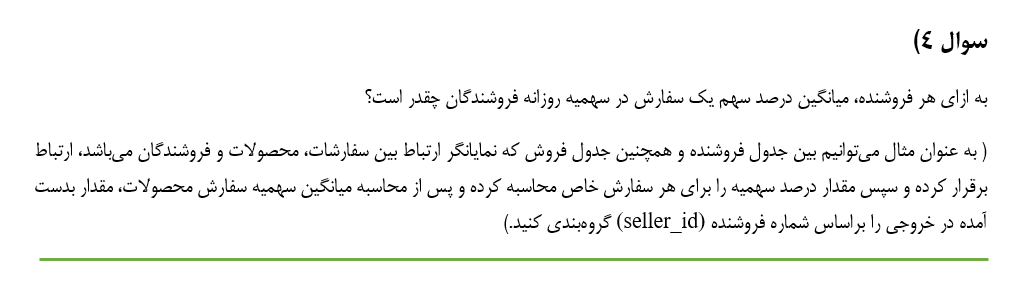

##calculate with **daily_target**

In [16]:
joint_df = sales_df.join(products_df, ['product_id'], "inner").\
           withColumn("total_price", col("price") * col("num_pieces_sold")).\
           select('seller_id', 'order_id', 'date', 'total_price').join(sellers_df, ['seller_id'])
joint_df.printSchema()

root
 |-- seller_id: string (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- total_price: integer (nullable = true)
 |-- seller_name: string (nullable = true)
 |-- daily_target: integer (nullable = true)



In [17]:
joint_df.withColumn('share_percent', col('total_price')*100/col('daily_target')).\
         select('seller_id', 'share_percent').groupBy('seller_id').mean().show()

+---------+-------------------+
|seller_id| avg(share_percent)|
+---------+-------------------+
|        7| 0.1960124630631757|
|        3| 1.2318678193054804|
|        8|  0.694606099856396|
|        5| 0.3170589299015149|
|        6|0.36093852517481845|
|        9| 0.2905299815673646|
|        1| 1.4844178645806256|
|        4|0.24841173704802313|
|        2| 0.5064829818617168|
|        0| 0.0444374897765487|
+---------+-------------------+



##calculate without **daily_target**

- join the sales and product dataframes
- calculate total_price

In [18]:
joint_df = sales_df.join(products_df, ['product_id'], "inner").\
           withColumn("total_price", col("price") * col("num_pieces_sold"))
joint_df.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- num_pieces_sold: integer (nullable = true)
 |-- bill_raw_text: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- total_price: integer (nullable = true)



caculate the income of seller each day

In [19]:
income_per_day = joint_df.select('total_price', 'seller_id', 'date').groupBy('date', 'seller_id').sum().\
                          withColumnRenamed("sum(total_price)","seller_income_per_day")

- join with income_per_day df
- caculate in percent
- group by based on seller to get mean of income percent for each order

In [20]:
joint_df.join(income_per_day, ['date', 'seller_id'], "inner").\
withColumn("seller_per_order_income", col("total_price") * 100 / col("seller_income_per_day")).\
select('seller_id', 'seller_per_order_income').groupby('seller_id').mean().show()

+---------+----------------------------+
|seller_id|avg(seller_per_order_income)|
+---------+----------------------------+
|        7|        0.009005763688760793|
|        3|        0.008982466225927004|
|        8|        0.009018596345664799|
|        0|        5.263157894748133E-5|
|        5|        0.009019247073254372|
|        6|        0.008983273145403231|
|        9|        0.008977305372019505|
|        1|        0.009024863498939557|
|        4|          0.0089953943580887|
|        2|         0.00899013781881275|
+---------+----------------------------+



# Question_5

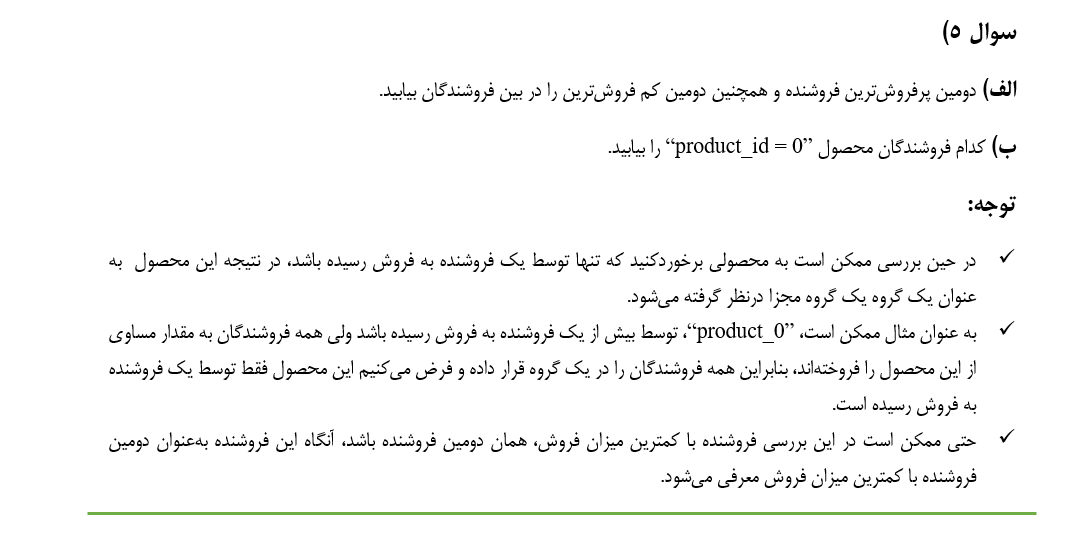

In [21]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, dense_rank, when

In [22]:
count_window = Window.orderBy(col('sum(num_pieces_sold)'))

In [23]:
seller_rank_sum = sales_df.select('num_pieces_sold', 'seller_id').groupBy('seller_id').sum().\
                           withColumn('rank', dense_rank().over(count_window))
max_value = seller_rank_sum.agg({'rank': 'max'}).first()['max(rank)']
max_value

10

In [24]:
seller_rank_sum.where((col('rank') == 2) | (col('rank') == (max_value - 1))).show()

+---------+--------------------+----+
|seller_id|sum(num_pieces_sold)|rank|
+---------+--------------------+----+
|        1|             5598683|   2|
|        9|             5634837|   9|
+---------+--------------------+----+



In [25]:
sales_df.select('num_pieces_sold', 'seller_id', 'product_id').groupBy('seller_id', 'product_id').sum().show()

+---------+----------+--------------------+
|seller_id|product_id|sum(num_pieces_sold)|
+---------+----------+--------------------+
|        0|         0|           959445802|
|        6|  71598950|                  45|
|        9|  40745956|                  28|
|        4|  70025887|                  58|
|        9|  14623915|                  68|
|        9|  57841735|                  51|
|        9|  55876917|                  11|
|        3|  61166403|                  79|
|        3|  26750979|                  79|
|        4|   7475511|                  62|
|        5|  58722902|                  13|
|        6|  25666047|                  55|
|        8|  48878702|                  76|
|        6|  72166578|                  90|
|        6|  15442804|                  55|
|        4|   1427289|                  93|
|        3|  10498036|                  78|
|        5|  12714089|                  53|
|        5|  35669585|                  13|
|        9|  65272164|          

In [26]:
count_window = Window.partitionBy('product_id').orderBy(col('sum(num_pieces_sold)'))
count_window_desc = Window.partitionBy('product_id').orderBy(desc('sum(num_pieces_sold)'))

In [27]:
sales_df.select('num_pieces_sold', 'seller_id', 'product_id').groupBy('seller_id', 'product_id').sum().\
withColumn('rank', dense_rank().over(count_window)).\
withColumn('rank_desc', dense_rank().over(count_window_desc)).\
where('product_id==0').\
where(((col('rank') == 2) |  (col('rank_desc') == 2))).show()

+---------+----------+--------------------+----+---------+
|seller_id|product_id|sum(num_pieces_sold)|rank|rank_desc|
+---------+----------+--------------------+----+---------+
+---------+----------+--------------------+----+---------+



# Question_6

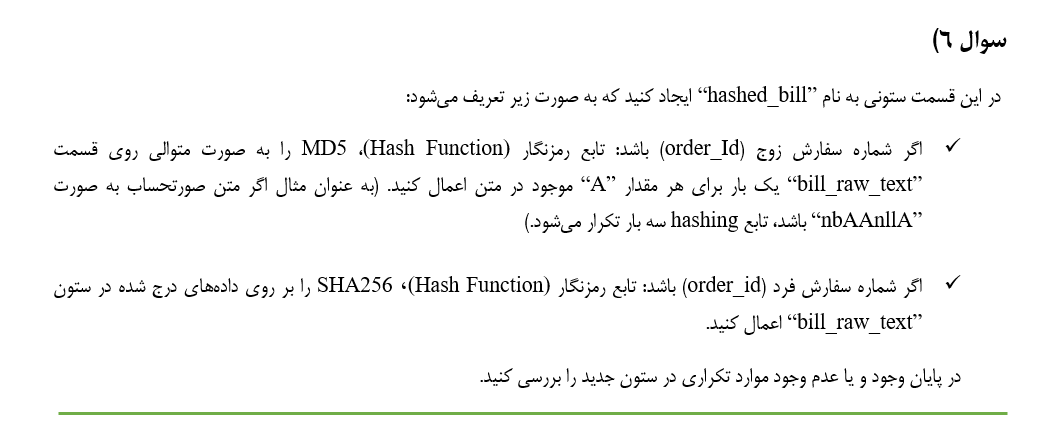

In [28]:
from pyspark.sql.functions import udf, when, md5, sha2, desc

In [29]:
import hashlib
def md5_hash(raw_text):
  hashed_text = raw_text
  a_count = raw_text.count('A')
  for _ in range(a_count):
    hashed_text = hashlib.md5(hashed_text.encode()).hexdigest()
  return hashed_text
  
even_hash_udf = udf(lambda z: md5_hash(z))

In [30]:
hashed_df = sales_df.withColumn('hashed_bill', 
                    when(col('order_id')%2==0, even_hash_udf(col('bill_raw_text'))).\
                    otherwise(sha2(col('bill_raw_text'), 256)))
hashed_df.select('hashed_bill').groupBy('hashed_bill').count().where('count > 1').sort(desc("hashed_bill")).show()

+-----------+-----+
|hashed_bill|count|
+-----------+-----+
+-----------+-----+

